In [89]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import FuncFormatter
import sqlite3
from pathlib import Path
from lmfit.models import LinearModel
from lmfit import Parameters, minimize, report_fit
import statsmodels.formula.api as smf
from scipy import constants

# Set Helvetica font globally
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Helvetica']

# Optional: make sure fonts are updated
mpl.rcParams['pdf.fonttype'] = 42  # Avoids Type 3 fonts in PDF output
mpl.rcParams['ps.fonttype'] = 42

mpl.rcParams["lines.linewidth"] = 0.5
mpl.rcParams["axes.linewidth"] = 0.5

mpl.rcParams.update({
    "xtick.major.width": 0.5,
    "ytick.major.width": 0.5,
    "xtick.minor.width": 0.5,
    "ytick.minor.width": 0.5,
})

# set font size
mpl.rcParams.update({'font.size': 8})

def thousands(x, pos):
    'The two args are the value and tick position, helper fn'
    return '%1.2f' % (x * 1e3)

In [90]:
nmr_energies_wt = pd.read_csv('../NMR_imino/fourU_imino_ref_WT_Rinnenthal2011_processed.csv')
nmr_energies_wt['disp_name'] = '4U_wt'
nmr_energies_a8c = pd.read_csv('../NMR_imino/fourU_imino_ref_A8C_Rinnenthal2011_processed.csv')
nmr_energies_a8c['disp_name'] = '4U_a8c'
nmr_energies = pd.concat([nmr_energies_wt, nmr_energies_a8c], ignore_index=True)

nn_energies_wt = pd.read_csv('../NNensemble/fourU/WT_25C.csv')
nn_energies_wt['disp_name'] = '4U_wt'
nn_energies_a8c = pd.read_csv('../NNensemble/fourU/A8C_25C.csv')
nn_energies_a8c['disp_name'] = '4U_a8c'
nn_energies = pd.concat([nn_energies_wt, nn_energies_a8c], ignore_index=True)

reactivities_wt = pd.read_csv('../reactivity_and_derivatives/ln_reactivity_25C_4U_wt.csv').drop(columns=['ln_reactivity_15min', 'ln_reactivity_infinity'])
reactivities_wt['disp_name'] = '4U_wt'
reactivities_a8c = pd.read_csv('../reactivity_and_derivatives/ln_reactivity_25C_4U_a8c.csv').drop(columns=['ln_reactivity_15min', 'ln_reactivity_infinity'])
reactivities_a8c['disp_name'] = '4U_a8c'
reactivities = pd.concat([reactivities_wt, reactivities_a8c], ignore_index=True)

reactivities

,site,base,fmod_15min,fmod_infinity,disp_name
0,7,A,0.006983,0.027730,4U_wt
1,8,A,0.008601,0.032709,4U_wt
2,9,C,0.005583,0.015494,4U_wt
3,15,A,0.002617,0.009353,4U_wt
4,16,A,0.002785,0.008399,4U_wt
5,18,A,0.019296,0.080084,4U_wt
6,22,A,0.005573,0.017369,4U_wt
7,25,C,0.001890,0.003525,4U_wt
8,26,A,0.002146,0.007155,4U_wt
9,29,A,0.001510,0.005479,4U_wt


In [91]:
def calculate_r2_from_fit(merged_dG, x_col = 'dG', y_col = 'dG_imino', x_label = 'DMS', y_label = 'NMR'):
    linear_model = LinearModel()
    params = linear_model.guess(merged_dG[y_col], x=merged_dG[x_col])
    result = linear_model.fit(merged_dG[y_col], params, x=merged_dG[x_col])

    # calculate r2
    r2 = result.rsquared
    return r2

In [92]:
def plot_linear_correlation(
    merged_dG,
    x_col='dG',
    y_col='dG_imino',
    x_err_col='dG_err',
    y_err_col='dG_err_imino',
    x_label='DMS',
    y_label='NMR',
    construct='4U',
    temp=20,
):
    linear_model = LinearModel()
    params = linear_model.guess(merged_dG[y_col], x=merged_dG[x_col])
    result = linear_model.fit(merged_dG[y_col], params, x=merged_dG[x_col])

    print(result.fit_report())

    fig, ax = plt.subplots(figsize=(2, 2))
    ax.scatter(merged_dG[x_col], merged_dG[y_col], color='black', s=8)
    ax.plot(merged_dG[x_col], result.best_fit, color='black', linewidth=1)

    # ---- plot errors only if requested ----
    plot_xerr = x_err_col not in (None, 'none')
    plot_yerr = y_err_col not in (None, 'none')

    if plot_xerr or plot_yerr:
        for i in range(len(merged_dG)):
            x = merged_dG[x_col].iloc[i]
            y = merged_dG[y_col].iloc[i]

            x_err = merged_dG[x_err_col].iloc[i] if plot_xerr else None
            y_err = merged_dG[y_err_col].iloc[i] if plot_yerr else None

            ax.errorbar(
                x, y,
                xerr=x_err,
                yerr=y_err,
                fmt='none',
                color='black',
                capsize=1,
                elinewidth=0.5,
            )

    label = r'$\Delta G_{XXX, TTT^\circ\mathrm{C}}$ (kcal/mol)'
    label = label.replace('TTT', str(temp))
    ax.set_xlabel(label.replace('XXX', x_label))
    ax.set_ylabel(label.replace('XXX', y_label))

    if x_label == 'endpt':
        ax.set_xlabel('ln(Mut. Rate)')
    elif x_label == 'endpt2':
        ax.set_xlabel('Pseudo-free energy (kcal/mol)')
    if y_label == 'endpt':
        ax.set_ylabel('ln(Mut. Rate)')
    elif y_label == 'endpt2':
        ax.set_ylabel('Pseudo-free energy (kcal/mol)')

    # ax.set_ylim(1, 5)

    r2 = result.rsquared
    ax.annotate(
        f'$R^2$ = {r2:.2f}',
        xy=(0.95, 0.05),
        xycoords='axes fraction',
        fontsize=9,
        ha='right',
        va='bottom',
    )

    plt.tight_layout()
    plt.savefig(f'{construct}_{y_label}_v_{x_label}.pdf')
    print(f'Saving figure as {construct}_{y_label}_v_{x_label}.pdf')
    plt.show()

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 4
    # data points      = 13
    # variables        = 2
    chi-square         = 317.226731
    reduced chi-square = 28.8387937
    Akaike info crit   = 45.5306762
    Bayesian info crit = 46.6605749
    R-squared          = 0.00699239
[[Variables]]
    slope:     -66.4769049 +/- 238.856976 (359.31%) (init = -66.47691)
    intercept: -23.7625814 +/- 140.846621 (592.72%) (init = -23.76258)
[[Correlations]] (unreported correlations are < 0.100)
    C(slope, intercept) = +0.9999
Saving figure as 4U_NMR_v_Pseudo.pdf


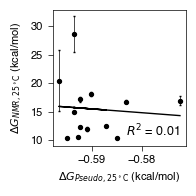

In [93]:
# correlation against default pseudoenergy
m = 1.8
b = -0.6

r_v_nmr = pd.merge(reactivities, nmr_energies, on=['site', 'disp_name'], suffixes=('_r', '_nmr'))
r_v_nmr['dG_pseudo'] = m * np.log(r_v_nmr['fmod_infinity'] + 1) + b

plot_linear_correlation(r_v_nmr, x_col='dG_pseudo', x_err_col = None, y_col='dG', y_err_col = 'dG_err', x_label='Pseudo', y_label='NMR', construct='4U', temp=25)

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


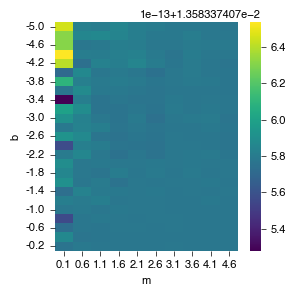

In [122]:
r_v_nmr = pd.merge(reactivities, nmr_energies, on=['site', 'disp_name'], suffixes=('_r', '_nmr'))
calculate_r2_from_fit(r_v_nmr, x_col='fmod_infinity', y_col='dG_calc_25')

mat_result = []

# grid search for m and b
for m in np.arange(0.1, 5, 0.5):
    for b in np.arange(-5, 0, 0.2):
        # m round to 1 decimal
        m = round(m, 1)
        b = round(b, 1)
        r_v_nmr['dG_pseudo'] = m * np.log(r_v_nmr['fmod_infinity'] + 1) + b
        r2 = calculate_r2_from_fit(r_v_nmr, x_col='dG_pseudo', y_col='dG_calc_25')
        # store in mat_result
        mat_result.append((m, b, r2))

# heatmap
mat_result_df = pd.DataFrame(mat_result, columns=['m', 'b', 'r2'])
pivot_table = mat_result_df.pivot(index='b', columns='m', values='r2')
plt.figure(figsize=(3, 3))
sns.heatmap(pivot_table, cmap='viridis')
plt.xlabel('m')
plt.ylabel('b')
plt.tight_layout()
plt.savefig('pseudoenergy_heatmap_nmr.pdf')
plt.show()

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 4
    # data points      = 21
    # variables        = 2
    chi-square         = 31.7897986
    reduced chi-square = 1.67314729
    Akaike info crit   = 12.7070830
    Bayesian info crit = 14.7961279
    R-squared          = 0.54812878
[[Variables]]
    slope:     -35.2055127 +/- 7.33330771 (20.83%) (init = -35.20551)
    intercept: -17.0580883 +/- 4.18524813 (24.54%) (init = -17.05809)
[[Correlations]] (unreported correlations are < 0.100)
    C(slope, intercept) = +0.9977
Saving figure as 4U_NN_v_Pseudo.pdf


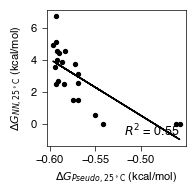

In [95]:
# correlation against default pseudoenergy
m = 1.8
b = -0.6

r_v_nn = pd.merge(reactivities, nn_energies, on=['site', 'disp_name'], suffixes=('_r', '_nn'))
r_v_nn['dG_pseudo'] = m * np.log(r_v_nn['fmod_infinity'] + 1) + b

plot_linear_correlation(r_v_nn, x_col='dG_pseudo', x_err_col = None, y_col='dG', y_err_col = None, x_label='Pseudo', y_label='NN', construct='4U', temp=25)

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


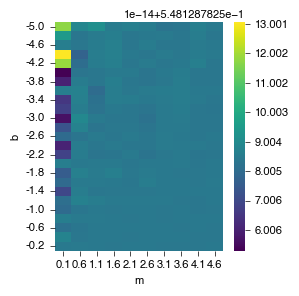

In [123]:
r_v_nn = pd.merge(reactivities, nn_energies, on=['site', 'disp_name'], suffixes=('_r', '_nn'))
calculate_r2_from_fit(r_v_nn, x_col='fmod_infinity', y_col='dG')

# try pseudoenergy
m = 5
b = -0.6

mat_result = []

# grid search for m and b
for m in np.arange(0.1, 5, 0.5):
    for b in np.arange(-5, 0, 0.2):
        # m round to 1 decimal
        m = round(m, 1)
        b = round(b, 1)
        r_v_nn['dG_pseudo'] = m * np.log(r_v_nn['fmod_infinity'] + 1) + b
        r2 = calculate_r2_from_fit(r_v_nn, x_col='dG_pseudo', y_col='dG')
        # store in mat_result
        mat_result.append((m, b, r2))

# heatmap
mat_result_df = pd.DataFrame(mat_result, columns=['m', 'b', 'r2'])
pivot_table = mat_result_df.pivot(index='b', columns='m', values='r2')
plt.figure(figsize=(3, 3))
sns.heatmap(pivot_table, cmap='viridis')


# yticklabel 1 decimal
# plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
plt.xlabel('m')
plt.ylabel('b')
plt.tight_layout()
plt.savefig('pseudoenergy_heatmap_nn.pdf')
plt.show()

In [110]:
pivot_table

m,0.1,0.6,1.1,1.6,2.1,2.6,3.1,3.6,4.1,4.6
b,,,,,,,,,,
-5.0,0.548129,0.548129,0.548129,0.548129,0.548129,0.548129,0.548129,0.548129,0.548129,0.548129
-4.9,0.548129,0.548129,0.548129,0.548129,0.548129,0.548129,0.548129,0.548129,0.548129,0.548129
-4.8,0.548129,0.548129,0.548129,0.548129,0.548129,0.548129,0.548129,0.548129,0.548129,0.548129
-4.7,0.548129,0.548129,0.548129,0.548129,0.548129,0.548129,0.548129,0.548129,0.548129,0.548129
-4.6,0.548129,0.548129,0.548129,0.548129,0.548129,0.548129,0.548129,0.548129,0.548129,0.548129
-4.5,0.548129,0.548129,0.548129,0.548129,0.548129,0.548129,0.548129,0.548129,0.548129,0.548129
-4.4,0.548129,0.548129,0.548129,0.548129,0.548129,0.548129,0.548129,0.548129,0.548129,0.548129
-4.3,0.548129,0.548129,0.548129,0.548129,0.548129,0.548129,0.548129,0.548129,0.548129,0.548129
-4.2,0.548129,0.548129,0.548129,0.548129,0.548129,0.548129,0.548129,0.548129,0.548129,0.548129
